In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt

In [2]:
# Get constants
with open("params_train.json", 'r') as file:
    params = json.load(file)

agent_name      = params['training']['AGENT_NAME']
model_name      = params['training']['MODEL_NAME']
training_rounds = params['training']['TRAINING_ROUNDS']

alpha  = params['Q-update']['ALPHA']
gamma  = params['Q-update']['GAMMA']
mode   = params['Q-update']['MODE']
n_step = params['Q-update']['N']

print(f"Trained 'agent_{agent_name}_{model_name}' for {training_rounds} rounds.")
print(f"Performed Q-update in {n_step}-step {mode} mode.  (alpha = {alpha}, gamma = {gamma})")

Trained 'agent_h2_debug_test_2' for 1000 rounds.
Performed Q-update in 5-step SARSA mode.  (alpha = 0.1, gamma = 1)


In [3]:
# All possible features
all_direction_features = np.array(
    [
        [0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 1],
        [0, 1, 1, 1],
        [1, 1, 1, 1],
        [0, 0, 0, 2],
        [0, 0, 1, 2],
        [0, 1, 1, 2],
        [1, 1, 1, 2],
        [0, 0, 2, 2],
        [0, 1, 2, 2],
        [1, 1, 2, 2],
        [0, 2, 2, 2],
        [1, 2, 2, 2],
        [2, 2, 2, 2],   
    ]
)
all_own_spot_features  = np.array([0, 1, 2])
all_mode_features      = np.array([0, 1, 2])  

### Evaluating the trained model

In [4]:
trained_model = np.load(f"model_{agent_name}_{model_name}.pt", allow_pickle = True)
policy        = np.argmax(trained_model, axis = -1)

In [5]:
def look_up_q_tensor(f5, f6):
    print(f"Q-Tensor for case (f5 = {f5}, f6 = {f6}):")
    print("state  direction features   policy  trained model")
    for i in range(len(all_direction_features)):
        line = f"{i:2}{'':5}{all_direction_features[i]} {[f5, f6]} {'':4}{policy[i, f5, f6]}{'':7}["
        for Q_value in trained_model[i, f5, f6]:
            line += f"{Q_value:-7.3f}"
        line += "]"
        print(line)

In [6]:
look_up_q_tensor(2, 2)

Q-Tensor for case (f5 = 2, f6 = 2):
state  direction features   policy  trained model
 0     [0 0 0 0] [2, 2]     4       [ -0.264 -0.100 -0.108 -0.300  1.998 -0.200]
 1     [0 0 0 1] [2, 2]     5       [  4.244  6.948 -0.282  7.591  4.951 16.326]
 2     [0 0 1 1] [2, 2]     3       [ -0.100  4.980  3.131 16.931  0.400  0.036]
 3     [0 1 1 1] [2, 2]     3       [  0.000 -0.086  1.358 21.645  0.000  0.000]
 4     [1 1 1 1] [2, 2]     0       [  0.000  0.000  0.000  0.000  0.000  0.000]
 5     [0 0 0 2] [2, 2]     4       [  0.483 -0.300 -0.369  0.185 13.723 -0.207]
 6     [0 0 1 2] [2, 2]     4       [ 12.092  8.934 12.958 12.938 14.636 11.390]
 7     [0 1 1 2] [2, 2]     3       [  4.874  7.421  3.552 17.484  1.776  1.860]
 8     [1 1 1 2] [2, 2]     0       [ 17.187  4.376  6.022  4.601  3.741  5.547]
 9     [0 0 2 2] [2, 2]     2       [  0.000  0.000  6.285  0.000  0.000  0.000]
10     [0 1 2 2] [2, 2]     0       [  0.592  0.000 -0.059  0.000  0.000  0.000]
11     [1 1 2 2] [2, 2]

## Looking at the training process

### Training performance over rounds

In [7]:
with open("results_train.json") as file:
    training_results = json.load(file)

In [8]:
number_of_rounds = training_results['by_agent'][f"agent_{agent_name}"]['rounds']

round_list      = list(training_results['by_round'])
rounds          = np.zeros(number_of_rounds)
collected_coins = np.zeros(number_of_rounds)
round_lengths   = np.zeros(number_of_rounds)
for i, round_name in enumerate(round_list):
    round              = training_results['by_round'][round_name]
    collected_coins[i] = round['coins']
    round_lengths[i]   = round['steps']
    rounds[i]          = round['round']

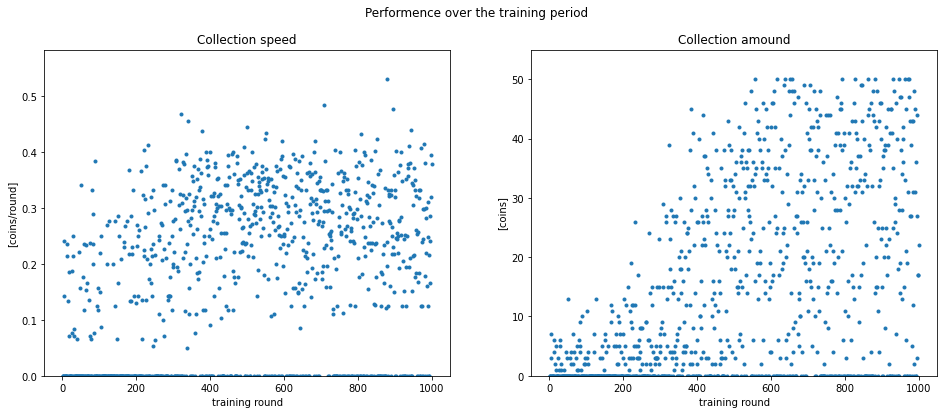

In [9]:
plt.figure(figsize = (16,6))
plt.suptitle("Performence over the training period")
plt.subplot(1, 2, 1)
speed = collected_coins / round_lengths
plt.plot(rounds, speed, '.')
plt.ylim((0, 1.1*max(speed)))
plt.title("Collection speed")
plt.ylabel("[coins/round]")   # speed of 0.4 would be considerad great performance
plt.xlabel("training round")

plt.subplot(1, 2, 2)
plt.plot(rounds, collected_coins, '.')
plt.ylim((0, 1.1*max(collected_coins)))
plt.title("Collection amount")
plt.ylabel("[coins]")   # speed of 0.4 would be considerad great performance
plt.xlabel("training round")
plt.show()

In [10]:
def analyze_action():
    Q_action = np.mean(allQs, axis = (1,2,3))
    labels  = ["action 0", "action 1", "action 2", "action 3", "WAIT", "BOMB"]

    plt.plot(np.arange(number_of_rounds) + 1, Q_action, label = labels)
    plt.title(f"Evolution of actions")
    plt.ylabel("Mean Q-value")
    plt.xlabel("training round")
    plt.legend()
    plt.show()

In [11]:
def analyze_state (state):
    state_index, f5, f6 = state
    Q_state = allQs[:, state_index, f5, f6]
    labels  = ["action 0", "action 1", "action 2", "action 3", "WAIT", "BOMB"]

    plt.plot(np.arange(training_rounds) + 1, Q_state, label = labels)
    plt.title(f"Evolution of state {state}")
    plt.ylabel("Q-value")
    plt.xlabel("training round")
    plt.legend()
    plt.show()

### Evolution of the Q-model

In [12]:
allQs = np.load("Qtrain.npy")

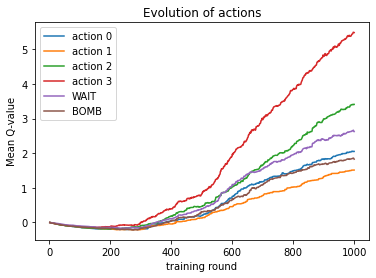

In [13]:
analyze_action()

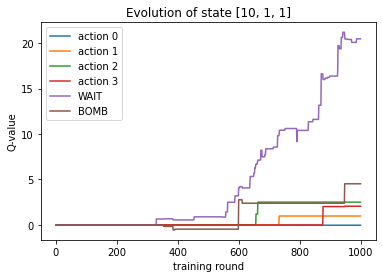

In [15]:
analyze_state([10, 1, 1])